In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2026-02-15 14:45:14.337236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771166714.585584      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771166714.656563      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771166715.236180      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771166715.236261      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771166715.236264      17 computation_placer.cc:177] computation placer alr

/kaggle/input/remote-work-burnout-and-social-isolation-2026/viz_07_burnout_score_distribution.png
/kaggle/input/remote-work-burnout-and-social-isolation-2026/wfh_burnout_dataset.csv
/kaggle/input/remote-work-burnout-and-social-isolation-2026/viz_03_workhours_burnout_scatter.png
/kaggle/input/remote-work-burnout-and-social-isolation-2026/viz_04_employee_archetypes.png
/kaggle/input/remote-work-burnout-and-social-isolation-2026/viz_08_meetings_multitasking.png
/kaggle/input/remote-work-burnout-and-social-isolation-2026/viz_05_sleep_fatigue_analysis.png
/kaggle/input/remote-work-burnout-and-social-isolation-2026/viz_01_burnout_distribution.png
/kaggle/input/remote-work-burnout-and-social-isolation-2026/viz_02_correlation_heatmap.png
/kaggle/input/remote-work-burnout-and-social-isolation-2026/viz_06_feature_importance.png


In [2]:
ds = pd.read_csv('/kaggle/input/remote-work-burnout-and-social-isolation-2026/wfh_burnout_dataset.csv')
ds.head(6)

,user_id,day_type,work_hours,screen_time_hours,meetings_count,breaks_taken,after_hours_work,app_switches,sleep_hours,task_completion,isolation_index,fatigue_score,burnout_score,burnout_risk
0,129,Weekday,7.74,5.99,3,7,0,50,7.50,74.80,4,3.51,17.23,Low
1,24,Weekday,8.48,7.23,3,5,0,63,7.31,86.36,4,5.15,24.01,Low
2,147,Weekend,8.39,7.14,1,5,0,27,6.73,89.23,8,7.85,51.46,Medium
3,42,Weekday,12.48,12.23,4,1,1,89,6.55,64.47,5,10.00,55.50,Medium
4,99,Weekend,8.85,7.35,4,6,0,40,8.03,98.62,3,3.45,11.95,Low
5,54,Weekday,9.43,7.68,2,7,0,41,6.78,70.52,5,5.83,34.58,Medium


In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            2000 non-null   int64  
 1   day_type           2000 non-null   object 
 2   work_hours         2000 non-null   float64
 3   screen_time_hours  2000 non-null   float64
 4   meetings_count     2000 non-null   int64  
 5   breaks_taken       2000 non-null   int64  
 6   after_hours_work   2000 non-null   int64  
 7   app_switches       2000 non-null   int64  
 8   sleep_hours        2000 non-null   float64
 9   task_completion    2000 non-null   float64
 10  isolation_index    2000 non-null   int64  
 11  fatigue_score      2000 non-null   float64
 12  burnout_score      2000 non-null   float64
 13  burnout_risk       2000 non-null   object 
dtypes: float64(6), int64(6), object(2)
memory usage: 218.9+ KB


In [4]:
#how mayn different type of distinct values
print(ds['day_type'].value_counts())
print(ds['burnout_risk'].value_counts())

day_type
Weekday    1435
Weekend     565
Name: count, dtype: int64
burnout_risk
Low       1019
Medium     843
High       138
Name: count, dtype: int64


In [5]:
missing_values = ds.isnull().sum()
print(missing_values[missing_values > 0] if any(missing_values > 0) else "No missing values")

No missing values


In [6]:
ds.drop(columns=['user_id'], inplace=True)


In [7]:
# after_hours_work should be binary
ds['after_hours_work'] = ds['after_hours_work'].astype(int)

# meetings_count, breaks_taken, app_switches should be integers
int_cols = ['meetings_count', 'breaks_taken', 'app_switches', 'isolation_index']
ds[int_cols] = ds[int_cols].astype(int)


In [8]:
# Screen time should not exceed work hours by extreme margins
ds['screen_work_ratio'] = ds['screen_time_hours'] / ds['work_hours']


In [9]:
ds['screen_work_ratio'] = ds['screen_work_ratio'].clip(0, 2.5)


In [10]:
ds['day_type'] = ds['day_type'].map({'Weekday': 0, 'Weekend': 1})


In [11]:
ds.groupby('day_type').size()


day_type
0    1435
1     565
dtype: int64

In [12]:

le = LabelEncoder()
ds['burnout_risk'] = le.fit_transform(ds['burnout_risk'])

print(dict(zip(le.classes_, le.transform(le.classes_))))


{'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}


In [13]:
#outlier
num_cols = ds.select_dtypes(include=['float64', 'int64']).columns
num_cols = num_cols.drop('burnout_risk')

for col in num_cols:
    q1 = ds[col].quantile(0.01)
    q99 = ds[col].quantile(0.99)
    ds[col] = ds[col].clip(q1, q99)


In [14]:
X = ds.drop(columns=['burnout_risk'])
y = ds['burnout_risk']


In [15]:
X.info()
y.value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   day_type           2000 non-null   int64  
 1   work_hours         2000 non-null   float64
 2   screen_time_hours  2000 non-null   float64
 3   meetings_count     2000 non-null   int64  
 4   breaks_taken       2000 non-null   int64  
 5   after_hours_work   2000 non-null   int64  
 6   app_switches       2000 non-null   int64  
 7   sleep_hours        2000 non-null   float64
 8   task_completion    2000 non-null   float64
 9   isolation_index    2000 non-null   int64  
 10  fatigue_score      2000 non-null   float64
 11  burnout_score      2000 non-null   float64
 12  screen_work_ratio  2000 non-null   float64
dtypes: float64(7), int64(6)
memory usage: 203.3 KB


burnout_risk
1    0.5095
2    0.4215
0    0.0690
Name: proportion, dtype: float64

In [16]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   day_type           2000 non-null   int64  
 1   work_hours         2000 non-null   float64
 2   screen_time_hours  2000 non-null   float64
 3   meetings_count     2000 non-null   int64  
 4   breaks_taken       2000 non-null   int64  
 5   after_hours_work   2000 non-null   int64  
 6   app_switches       2000 non-null   int64  
 7   sleep_hours        2000 non-null   float64
 8   task_completion    2000 non-null   float64
 9   isolation_index    2000 non-null   int64  
 10  fatigue_score      2000 non-null   float64
 11  burnout_score      2000 non-null   float64
 12  burnout_risk       2000 non-null   int64  
 13  screen_work_ratio  2000 non-null   float64
dtypes: float64(7), int64(7)
memory usage: 218.9 KB


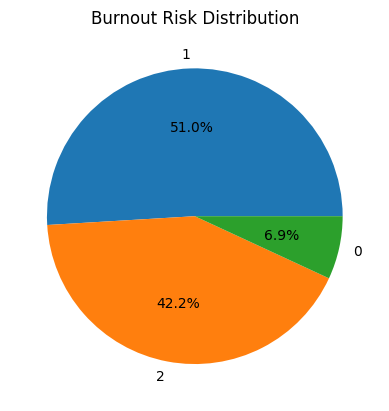

In [17]:
plt.figure()
ds['burnout_risk'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%'
)
plt.title('Burnout Risk Distribution')
plt.ylabel('')
plt.show()


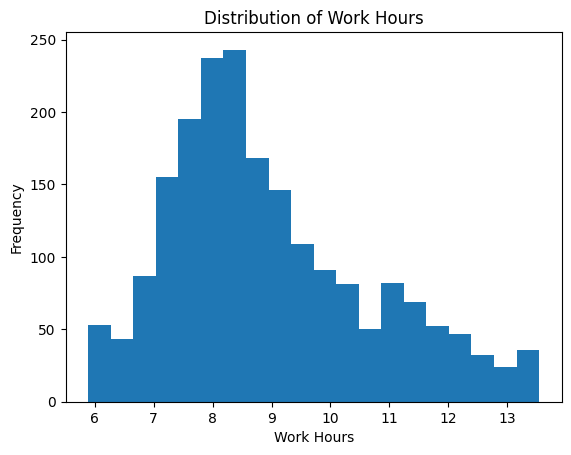

In [18]:
plt.figure()
plt.hist(ds['work_hours'], bins=20)
plt.title('Distribution of Work Hours')
plt.xlabel('Work Hours')
plt.ylabel('Frequency')
plt.show()


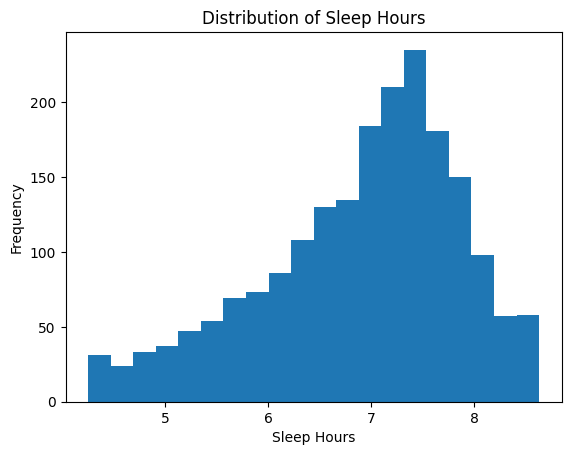

In [19]:
plt.figure()
plt.hist(ds['sleep_hours'], bins=20)
plt.title('Distribution of Sleep Hours')
plt.xlabel('Sleep Hours')
plt.ylabel('Frequency')
plt.show()


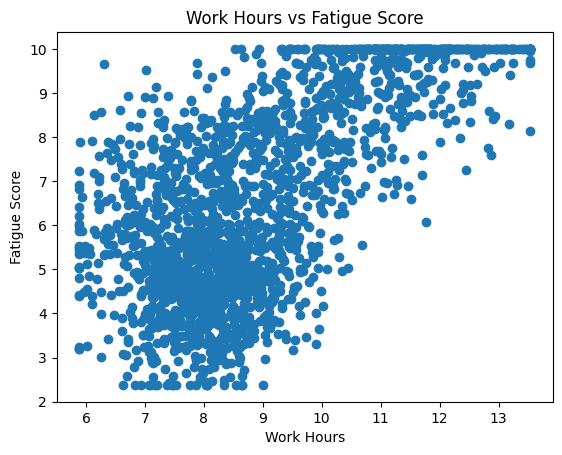

In [20]:
plt.figure()
plt.scatter(ds['work_hours'], ds['fatigue_score'])
plt.title('Work Hours vs Fatigue Score')
plt.xlabel('Work Hours')
plt.ylabel('Fatigue Score')
plt.show()


<Figure size 640x480 with 0 Axes>

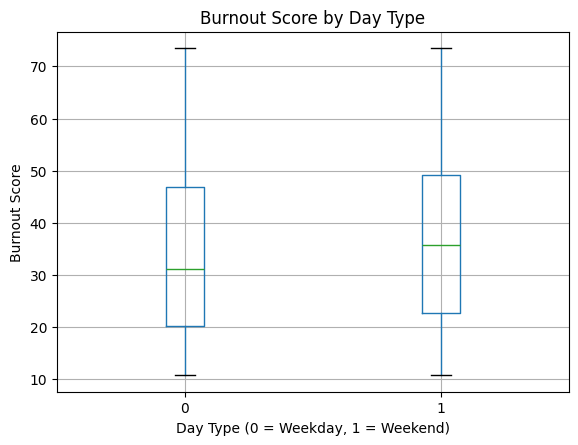

In [21]:
plt.figure()
ds.boxplot(column='burnout_score', by='day_type')
plt.title('Burnout Score by Day Type')
plt.suptitle('')
plt.xlabel('Day Type (0 = Weekday, 1 = Weekend)')
plt.ylabel('Burnout Score')
plt.show()


In [22]:
X = ds.drop(columns=['burnout_risk'])
y = ds['burnout_risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
 

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [24]:
#weighti = (N / (nclas *ni))
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Clip weights to a reasonable range
weights = np.clip(weights, 0.8, 2.0)  # min 0.8, max 2.0

# Convert to dictionary
class_weight_dict = dict(enumerate(weights))
class_weight_dict

{0: np.float64(2.0), 1: np.float64(0.8), 2: np.float64(0.8)}

In [25]:
model = Sequential([
    Dense(
        128,
        activation='relu',
        kernel_initializer=HeNormal(),
        input_shape=(X_train.shape[1],)
    ),
    BatchNormalization(),
    Dropout(0.4),

    Dense(
        64,
        activation='relu',
        kernel_initializer=HeNormal()
    ),
    BatchNormalization(),
    Dropout(0.3),

    Dense(
        32,
        activation='relu',
        kernel_initializer=HeNormal()
    ),
    BatchNormalization(),
    Dropout(0.2),

    Dense(3, activation='softmax')
])



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-02-15 14:45:31.470794: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [26]:
#sparse_categorical_crossentropy → measures how wrong the model is
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    verbose=1
)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.3f}")


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4277 - loss: 1.1434 - val_accuracy: 0.6531 - val_loss: 0.8287
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6917 - loss: 0.6385 - val_accuracy: 0.7781 - val_loss: 0.5783
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8047 - loss: 0.4495 - val_accuracy: 0.8250 - val_loss: 0.4843
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8172 - loss: 0.4083 - val_accuracy: 0.8469 - val_loss: 0.4075
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8505 - loss: 0.3380 - val_accuracy: 0.8844 - val_loss: 0.2928
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8846 - loss: 0.2942 - val_accuracy: 0.8750 - val_loss: 0.2981
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8635 - loss: 0.3000 - val_accuracy: 0.8844 - val_loss: 0.2567
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8910 - loss: 0.2496 - val_accuracy: 0.8875 - val_loss

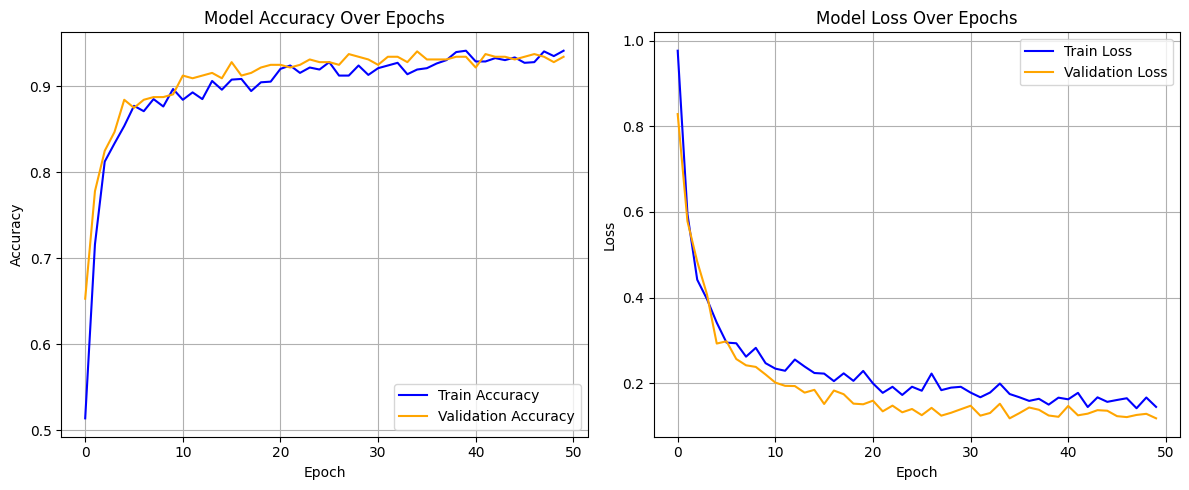

In [27]:
# Plot training & validation accuracy
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


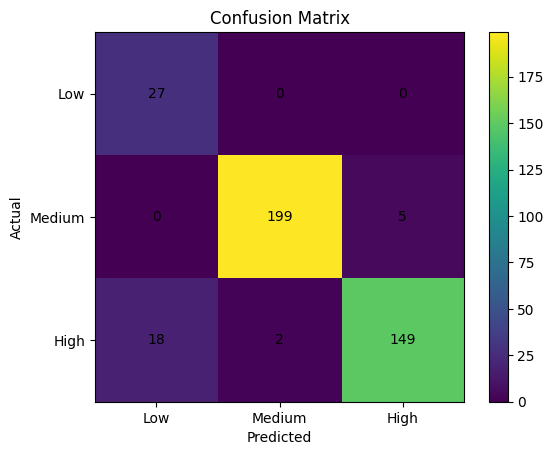

In [28]:

y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_test, y_pred)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()

labels = ['Low', 'Medium', 'High']
plt.xticks(range(3), labels)
plt.yticks(range(3), labels)

for i in range(3):
    for j in range(3):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.show()


In [29]:
# Pick a random row index from test set
idx = np.random.randint(0, X_test.shape[0])

sample = X_test[idx].reshape(1, -1)
true_label = y_test.iloc[idx]

pred_prob = model.predict(sample)
pred_class = np.argmax(pred_prob)

risk_map = {0: 'Low', 1: 'Medium', 2: 'High'}

print("🔍 RANDOM REAL USER PREDICTION")
print("--------------------------------")
print(f"ID     : {idx}")
print(f"True Burnout Risk     : {risk_map[true_label]}")
print(f"Predicted Burnout Risk: {risk_map[pred_class]}")
print(f"Prediction Confidence : {pred_prob[0][pred_class]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
🔍 RANDOM REAL USER PREDICTION
--------------------------------
ID     : 111
True Burnout Risk     : Low
Predicted Burnout Risk: Low
Prediction Confidence : 0.93


In [30]:
educational_sample = np.array([[
    0,      # day_type (0=Weekday)
    4.5,   # work_hours
    6.8,   # screen_time_hours
    5,      # meetings_count
    1,      # breaks_taken
    1,      # after_hours_work
    95,     # app_switches
    2.2,    # sleep_hours
    62.0,   # task_completion
    8,      # isolation_index
    9.1,    # fatigue_score
    99.0,   # burnout_score
    3.94    # screen_work_ratio
]])
educational_sample_scaled = scaler.transform(educational_sample)
edu_prob = model.predict(educational_sample_scaled)
edu_class = np.argmax(edu_prob)
print("🎓 EDUCATIONAL PREDICTION")
print("--------------------------------")
print(f"Predicted Burnout Risk: {risk_map[edu_class]}")
print(f"Confidence            : {edu_prob[0][edu_class]:.2f}")

print("\nWhy?")
print("- Long work hours")
print("- High screen time")
print("- Very few breaks")
print("- Poor sleep duration")
print("- High fatigue score")
print("- High isolation index")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
🎓 EDUCATIONAL PREDICTION
--------------------------------
Predicted Burnout Risk: High
Confidence            : 0.89

Why?
- Long work hours
- High screen time
- Very few breaks
- Poor sleep duration
- High fatigue score
- High isolation index


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
